<a href="https://colab.research.google.com/github/madhugopinathan/deep-nlu/blob/master/word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Word Embeddings

In [1]:
!pip install -U torchtext

     |████████████████████████████████| 61kB 2.2MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [0]:
import torch
import torchtext
from torchtext.vocab import GloVe
import umap

In [0]:
pd.options.display.max_colwidth=-1

## Visualize and explore neighbourhood of word embeddings (Glove)

In [5]:
glove = GloVe(name = '840B', dim = 300)

.vector_cache/glove.840B.300d.zip: 2.18GB [16:57, 2.14MB/s]                            
100%|█████████▉| 2195174/2196017 [04:48<00:00, 8536.44it/s]

In [0]:
def get_word_vec(word):
  assert word in glove.stoi, f"{word} is OOV!"
  vec = glove.vectors[glove.stoi[word]]
  return vec


def cosine_similarity(word1, word2):
  vec1 = get_word_vec(word1)
  vec2 = get_word_vec(word2)
  return torch.cosine_similarity(vec1.unsqueeze(0),
                                 vec2.unsqueeze(0)).item()


def get_nearest_neighbours(word_or_vec, n=10):
    vec = None
    if isinstance(word_or_vec, str):
        vec = get_word_vec(word_or_vec)
    else:
        vec = word_or_vec
        
    topn =  torch.argsort(torch.mv(glove.vectors, vec), descending=True)[:n]
        
    return [glove.itos[idx] for idx in topn]

In [0]:
def plot_embeddings(words):
  fig, axes = plt.subplots(nrows=len(words), 
                           ncols=1, 
                           sharex=True, 
                           figsize=(20,len(words)))

  for ax, w in zip(axes.flat, words):
    im = ax.imshow(glove.vectors[glove.stoi[w]].view(1,-1), 
                   cmap=plt.cm.coolwarm)
    ax.set_aspect('auto')

  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
  fig.colorbar(im, cax=cbar_ax)

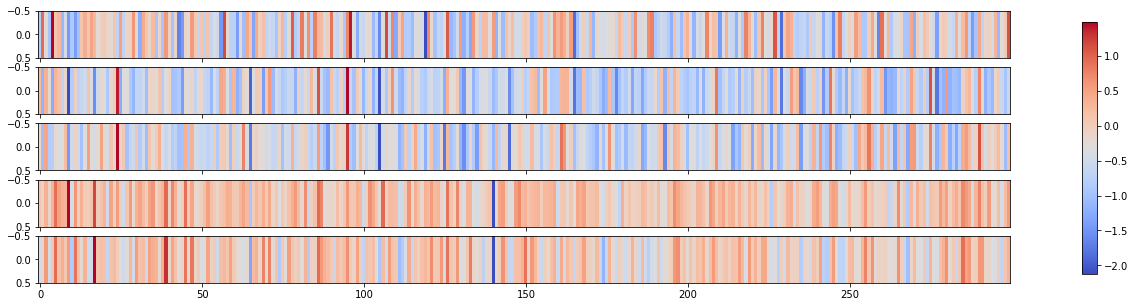

In [8]:
words = ['gurgaon','paratha','dosa', 'pizza', 'pasta']
plot_embeddings(words)

In [0]:
from sklearn.metrics.pairwise import cosine_similarity as mat_cosine_similarity

In [0]:
E = torch.stack([get_word_vec(w) for w in words], 
            dim=0)

In [0]:
csim = mat_cosine_similarity(E)

In [12]:
csim

array([[0.99999976, 0.13655838, 0.14006974, 0.01849766, 0.00368263],
       [0.13655838, 1.        , 0.69100374, 0.30521113, 0.3712668 ],
       [0.14006974, 0.69100374, 0.9999999 , 0.3093319 , 0.38042688],
       [0.01849766, 0.30521113, 0.3093319 , 0.9999999 , 0.7369544 ],
       [0.00368263, 0.3712668 , 0.38042688, 0.7369544 , 0.99999964]],
      dtype=float32)

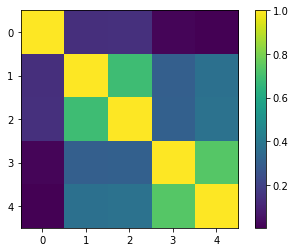

In [13]:
plt.imshow(csim)
plt.colorbar();

In [0]:
foods = ['chapati','chana','bhatura','chole','dal',
         'poha','idli','upma','dosa','puri',
         'paratha','jalebi','kachori','khichdi','kofta']

places = ['gurgaon','faridabad','lucknow','noida','delhi',
          'koramangala','bangalore','goa','panaji','coorg',
          'ladakh','amritsar','hyderabad','mumbai','varanasi'
         ]

food_places_df = pd.DataFrame(data={'word' : foods + places, 
                                    'type' : ['food'] * len(foods) + 
                                             ['place'] * len(places)})

In [15]:
food_places_df.sample(5)

,word,type
12,kachori,food
21,bangalore,place
5,poha,food
7,upma,food
9,puri,food


In [0]:
E = torch.stack([get_word_vec(row.word) for _,row in food_places_df.iterrows()], 
            dim=0)

In [17]:
E.shape

torch.Size([30, 300])

In [18]:
fit = umap.UMAP(n_neighbors=5, random_state=42, metric='cosine')
u = fit.fit_transform(E)

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


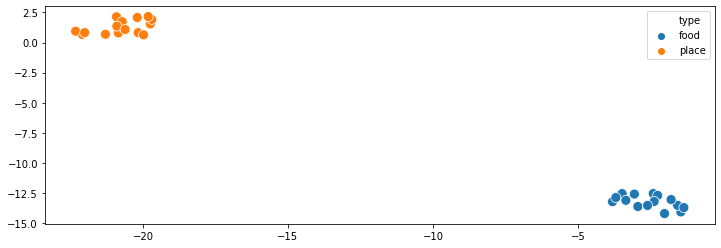

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
sns.scatterplot(u[:,0], u[:,1], ax=ax, hue=food_places_df.type, s=100);

In [20]:
glove.vectors.shape

torch.Size([2196017, 300])

In [0]:
num_points = 10000
indices = np.random.choice(glove.vectors.shape[0],size=num_points, 
                           replace=False)

E = glove.vectors[indices]
fit = umap.UMAP(n_neighbors=10, random_state=42, metric='cosine')
u = fit.fit_transform(E)

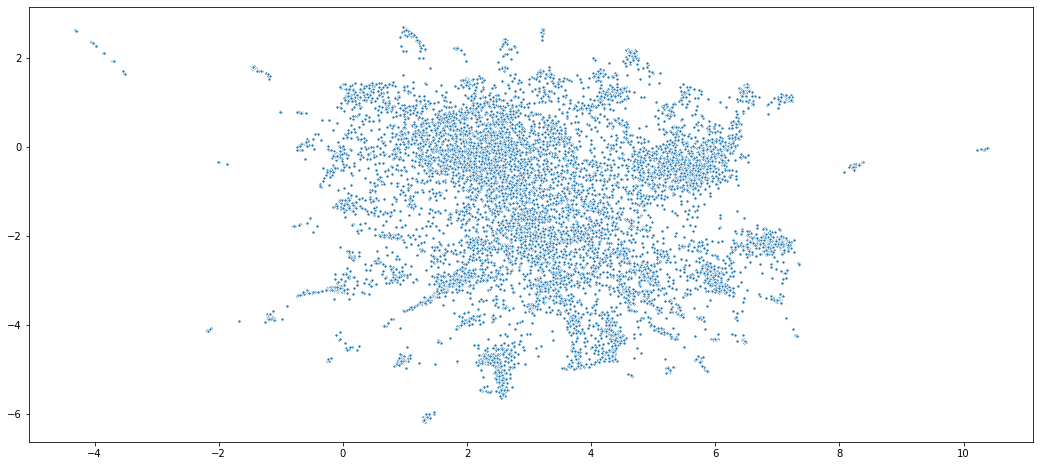

In [22]:
fig, ax = plt.subplots(figsize=(18,8))
sns.scatterplot(u[:,0], u[:,1], ax=ax, s=10);

## References
1. [The Illustrated Word2Vec](http://jalammar.github.io/illustrated-word2vec/)
1. [Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap)


In [0]:
def get_missing_word(a,b,c):
  avec = get_word_vec(a)
  bvec = get_word_vec(b)
  cvec = get_word_vec(c)
   
  dvec = cvec + bvec - avec
  candidates = get_nearest_neighbours(dvec, n=5)

  input_words = [a.lower(), b.lower(), c.lower()]
  candidates = [el for el in candidates if el.lower() not in input_words]
  return candidates[0]

In [24]:
get_missing_word('man','woman','king')

'queen'

In [25]:
get_missing_word('delhi','india','tokyo')

'japan'

In [26]:
get_missing_word('dosa','india','croissant')

'france'

## Representation of the gender concept

In [0]:
gender_pairs = [('she','he'),
                ('her','his'),
                ('woman','man'),
                ('daughter','son'),
                ('mother','father'),
               ]
words = [el for pair in gender_pairs for el in pair]
gender_df = pd.DataFrame(data={'gender' : ['female', 'male'] * len(gender_pairs),
                               'word' : words
                              })

In [28]:
gender_df

,gender,word
0,female,she
1,male,he
2,female,her
3,male,his
4,female,woman
5,male,man
6,female,daughter
7,male,son
8,female,mother
9,male,father


In [0]:
X = torch.stack([get_word_vec(w) for w in gender_df.word], dim=0)


In [30]:
X.shape

torch.Size([10, 300])

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [0]:
pipe = Pipeline([('scaler',StandardScaler()),
                 ('pca', PCA(n_components=2))
                ])

In [0]:
X_reduced = pipe.fit_transform(X)

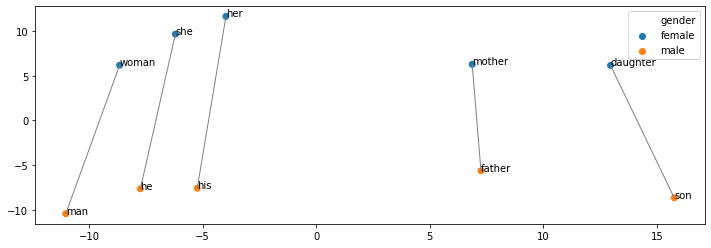

In [34]:
fig, ax = plt.subplots(figsize=(12,4))

sns.scatterplot(X_reduced[:,0], X_reduced[:,1], ax=ax, hue=gender_df.gender, s=60)

for i, word in enumerate(words):
    ax.annotate(word, (X_reduced[i,0], X_reduced[i,1]))
    
for i in range(0, X_reduced.shape[0], 2):
    ax.plot(X_reduced[i:i+2,0], X_reduced[i:i+2,1], c='gray', linewidth=1)

In [0]:
vecs = []
for i in range(0, X.shape[0], 2):
    a = X[i,:]
    b = X[i+1,:]
    mean_vec = (a+b)/2
    vecs.append(a-mean_vec)
    vecs.append(b-mean_vec)
X1 = torch.stack(vecs, dim=0)

In [0]:
X1_reduced = pipe.fit_transform(X1)


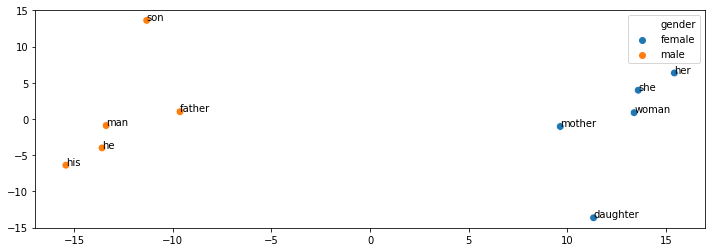

In [37]:
fig, ax = plt.subplots(figsize=(12,4))

sns.scatterplot(X1_reduced[:,0], X1_reduced[:,1], ax=ax, hue=gender_df.gender, s=60)

for i, word in enumerate(words):
    ax.annotate(word, (X1_reduced[i,0], X1_reduced[i,1]))

In [0]:
vecs = []
for i in range(0, X1.shape[0], 2):
    a = X[i,:]
    b = X[i+1,:]
    vecs.append(b-a)
X2 = torch.stack(vecs, dim=0)

In [0]:
gender_vector = X2.mean(dim=0)


In [0]:
def get_masculine_word(feminine_word):
  word_vector = get_word_vec(feminine_word)
  candidates = get_nearest_neighbours(word_vector + gender_vector)
  return [c for c in candidates if c not in [feminine_word, feminine_word+"s"]][0]

In [41]:
get_masculine_word('headmistress')

'headmaster'

In [42]:
get_masculine_word('daughter-in-law')


'son-in-law'

In [43]:
get_masculine_word('step-mother')


'step-father'

In [44]:
get_masculine_word('mother-in-law')


'father-in-law'

In [45]:
get_masculine_word('step-daughter')


'step-son'

In [46]:
get_masculine_word('stepdaughter')


'stepson'

In [47]:
get_masculine_word('policewoman')


'policeman'

In [48]:
get_masculine_word('chairwoman')


'chairman'

# Exercise: Compute the concept vector & predict!

pairs = [('good','bad'),
         ('beautiful','ugly'),
         ('interesting','boring'),
         ('clean','dirty'),
         ('safe','dangerous')]

test_words = ['terrific', 'fantastic', 'pretty', 'nice', 'innocent', 'expensive']

# Applications

* [Concept Search using Word Embeddings](https://cxlabs.sap.com/2018/06/11/concept-search-by-word-embeddings/)